In [1]:
#!pip install --upgrade covsirphy

In [2]:
import covsirphy as cs
cs.__version__

'2.15.0'

In [110]:
from IPython.display import IFrame, display
#filepath = "http://wikipedia.org" # works with websites too!
filepath = "../data/Images/CrispFramework.PNG"
IFrame(filepath, width=800, height=300)

### Business Understanding

1. The scope of this project is to develop a SIR Model for CANADA.
2. Simulate the Effectiveness of Lockdown.

### General Packages

In [137]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym
from scipy.integrate import odeint

### Plotting Configuration

In [4]:
# Ramdam
np.random.seed(123)
os.environ["PYTHONHASHSEED"] = "123"
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (15, 10)
# Pandas
pd.set_option("display.max_colwidth", 1000)

### Load Dataset

In [5]:
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


### Cleaned dataset is saved in jhu_data, lets load the dataset.

In [6]:
jhu_data.cleaned().head()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
0,2020-01-01,Afghanistan,-,0,0,0,0
1,2020-01-02,Afghanistan,-,0,0,0,0
2,2020-01-03,Afghanistan,-,0,0,0,0
3,2020-01-04,Afghanistan,-,0,0,0,0
4,2020-01-05,Afghanistan,-,0,0,0,0


### Creating Canada wide subset of data

In [7]:
jhu_data.subset("Canada", province=None)

,Date,Confirmed,Infected,Fatal,Recovered
0,2020-03-26,4018,3749,39,230
1,2020-03-27,4675,4366,53,256
2,2020-03-28,5386,4825,59,502
3,2020-03-29,6255,5672,61,522
4,2020-03-30,7424,6267,89,1068
...,...,...,...,...,...
320,2021-02-09,810797,39179,20909,750709
321,2021-02-10,813982,38242,21004,754736
322,2021-02-11,817163,37747,21088,758328
323,2021-02-12,820306,36944,21162,762200


### How many days have passed

In [8]:
df = jhu_data.cleaned()
jhu_first_date, jhu_last_date = df["Date"].min(), df["Date"].max()
jhu_elapsed = (jhu_last_date - jhu_first_date).days
print(f"{jhu_elapsed} days have passed from the date of the first record.")

409 days have passed from the date of the first record.


### Total Population
#### We need population values to calculate the number of "susceptible" cases.

Susceptible = Total population - Confirmed 

In [9]:
#Make use of dataloader to get population of Countries.
population_data = data_loader.population()
# Show cleaned dataset
population_data.cleaned().tail()
# show cleaned Canada data
population_data.value("Canada", province = None)

37057765

### Population pyramid

#### To estimate the average number of days people go out we going to use population pyramid

In [10]:
pyramid_data = data_loader.pyramid()

### Template Data (The average number of days people go out)

We are using the average number of days a person of each age group usually go out. The template is  provided by @marcoferrante.

In [11]:
# Estmation by marcoferrante

_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school", "high school", "university/work" , "work", "work", "work",
    "work", "retired", "retired", "retired"
]

df = pd.DataFrame({
    
    "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    
    
    
})

# Adjustment by @marcoferrante
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)


df["School"] = df[["Types","Days"]].apply(lambda x : x[1] if "school" in x[0] else 0, axis = 1)
df["Office"] = df[["Types", "Days"]].apply(lambda x : x[1] if "work" in x[0] else 0, axis =1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)

df.loc[df["Others"]<0, "Others"]=0
df.loc[df.index[1:5],"School"] -=1
df.loc[df.index[1:5],"Others"] +=1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(lambda x : x[1:]/sum(x[1:])*x[0], 
                                                                                      axis=1).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
# df = df.drop(["Days", "Types"], axis=1)



#show dataset
_out_df = df.copy()

_out_df.head(10)



,Age_first,Age_last,Period_of_life,Days,Types,School,Office,Others
0,0,2,nursery,3,school,3,0,0
1,3,5,nursery school,5,school,4,0,1
2,6,10,elementary school,6,school,5,0,1
3,11,13,middle school,6,school,5,0,1
4,14,18,high school,7,school,6,0,1
5,19,25,university/work,7,school/work,3,3,1
6,26,35,work,6,work,0,6,1
7,36,45,work,5,work,0,5,1
8,46,55,work,5,work,0,5,1
9,56,65,work,5,work,0,5,1


- Now this Pyramid data will be combined with Canada Specific Data.

In [12]:
def go_out(country, pyramid_data=pyramid_data):
    """
    Return the estimated number of days people usually go out.
    Args:
        country (str): coutry name
        pyramid_data (covsirphy.PopulationPyramidData): pyramid dataset
    
    Returns:
        pandas.DataFrame
    """
    p_df = pyramid_data.subset(country)
    p_df["Cumsum"] = p_df["Population"].cumsum()
    df = pd.merge(_out_df, p_df, left_on="Age_last", right_on="Age", how="left")
    df["Population"] = df["Cumsum"].diff()
    df.loc[df.index[0], "Population"] = df.loc[df.index[0], "Cumsum"]
    df["Population"] = df["Population"].astype(np.int64)
    df["Portion"] = df["Population"] / df["Population"].sum()
    return df.drop(["Per_total", "Cumsum"], axis=1)

go_out("Canada")

,Age_first,Age_last,Period_of_life,Days,Types,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,school,3,0,0,2,1193571,0.034264
1,3,5,nursery school,5,school,4,0,1,5,1193646,0.034266
2,6,10,elementary school,6,school,5,0,1,10,1987203,0.057047
3,11,13,middle school,6,school,5,0,1,13,1186425,0.034059
4,14,18,high school,7,school,6,0,1,18,2007971,0.057643
5,19,25,university/work,7,school/work,3,3,1,25,3365119,0.096603
6,26,35,work,6,work,0,6,1,35,5302920,0.152232
7,36,45,work,5,work,0,5,1,45,5012608,0.143898
8,46,55,work,5,work,0,5,1,55,4961567,0.142432
9,56,65,work,5,work,0,5,1,65,5165771,0.148294


### Data Cleaning: Linelist (COVID19_line_list_data.csv) <a href = "https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz">Link</a>

This dataset contains clinical trails of many reported case.


In [13]:
# linelist_raw = pd.read_csv("..\\data\\raw\\Covid-19_line_data.xlsx",header=0, encoding = 'unicode_escape')
# linelist_raw.head()

# import csv

# data = open(r"C://Users//yrsin//Desktop//w2021//SIRModel//sirmodel//data//raw//NewData.xlsx", encoding = 'unicode_escape')
# data = pd.read_csv(data)
# # print(data)


linelist_raw = pd.read_csv("../data/raw/test.csv")
linelist_raw.head()

,reporting date,location,country,gender,age,symptom_onset,If_onset_approximated,hosp_visit_date,international_traveler,domestic_traveler,exposure_start,exposure_end,traveler,visiting Wuhan,from Wuhan,death,recovered,symptom
0,1/20/2020,"Shenzhen, Guangdong",China,male,66.0,1/3/2020,0.0,1/11/2020,NaN,NaN,12/29/2019,1/4/2020,NaN,1.0,0.0,0,0,NaN
1,1/20/2020,Shanghai,China,female,56.0,1/15/2020,0.0,1/15/2020,NaN,NaN,NaN,1/12/2020,NaN,0.0,1.0,0,0,NaN
2,1/21/2020,Zhejiang,China,male,46.0,1/4/2020,0.0,1/17/2020,NaN,NaN,NaN,1/3/2020,NaN,0.0,1.0,0,0,NaN
3,1/21/2020,Tianjin,China,female,60.0,NaN,NaN,1/19/2020,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0,0,NaN
4,1/21/2020,Tianjin,China,male,58.0,NaN,NaN,1/14/2020,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0,NaN


In [14]:
linelist_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3397 entries, 0 to 3396
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   reporting date          3396 non-null   object 
 1   location                3167 non-null   object 
 2   country                 3234 non-null   object 
 3   gender                  1685 non-null   object 
 4   age                     1507 non-null   float64
 5   symptom_onset           684 non-null    object 
 6   If_onset_approximated   655 non-null    float64
 7   hosp_visit_date         620 non-null    object 
 8   international_traveler  826 non-null    float64
 9   domestic_traveler       802 non-null    float64
 10  exposure_start          194 non-null    object 
 11  exposure_end            488 non-null    object 
 12  traveler                660 non-null    float64
 13  visiting Wuhan          1606 non-null   float64
 14  from Wuhan              1602 non-null   

In [15]:
df = linelist_raw.loc[:, ~linelist_raw.columns.str.startswith("Unnamed:")]
# df = df.drop(["id", "case_in_country", "summary", "source", "link"], axis=1)
# Date
case_date_dict = {
    "reporting date": "Confirmed_date",
    "exposure_start": "Exposed_date",
    "exposure_end": "Quarantined_date",
    "hosp_visit_date": "Hospitalized_date",
    "symptom_onset": "Onset_date",
    "death": "Deaths_date",
    "recovered": "Recovered_date"    
}
df["death"] = df["death"].replace({"0": "", "1": ""})
df["recovered"] = df["recovered"].replace({"0": "", "1": "", "12/30/1899": "12/30/2019"})
# for (col, _) in case_date_dict.items():
#     df[col] = pd.to_datetime(df[col])
# df = df.rename(case_date_dict, axis=1)
df = df.rename(columns={"reporting date": "Confirmed_date",
    "exposure_start": "Exposed_date",
    "exposure_end": "Quarantined_date",
    "hosp_visit_date": "Hospitalized_date",
    "symptom_onset": "Onset_date",
    "death": "Deaths_date",
    "recovered": "Recovered_date" })
# df.head()
# Location
df["Country"] = df["country"].fillna("-")
df["Province"] = df["location"].fillna("-")
df["Province"] = df[["Country", "Province"]].apply(lambda x: "-" if x[0] == x[1] else x[1], axis=1)
# Personal
df["Gender"] = df["gender"].fillna("-").str.capitalize()
df["Age"] = df["age"].fillna(df["age"].median()).astype(np.int64) ## Fill in NA with median
df["From_Wuhan"] = df["from Wuhan"]
df["To_Wuhan"] = df["visiting Wuhan"]
# Medical
df["Events"] = df["symptom"].fillna("-")
# Order of columns
linelist_df = df.loc[
    :,
    [
        "Country", "Province",
        "Exposed_date", "Onset_date", "Hospitalized_date", "Confirmed_date", "Quarantined_date", "Deaths_date", "Recovered_date",
        "Events",
        "Gender", "Age", "From_Wuhan", "To_Wuhan"
    ]
]
linelist_df.head()

# df.head()

,Country,Province,Exposed_date,Onset_date,Hospitalized_date,Confirmed_date,Quarantined_date,Deaths_date,Recovered_date,Events,Gender,Age,From_Wuhan,To_Wuhan
0,China,"Shenzhen, Guangdong",12/29/2019,1/3/2020,1/11/2020,1/20/2020,1/4/2020,,,-,Male,66,0.0,1.0
1,China,Shanghai,NaN,1/15/2020,1/15/2020,1/20/2020,1/12/2020,,,-,Female,56,1.0,0.0
2,China,Zhejiang,NaN,1/4/2020,1/17/2020,1/21/2020,1/3/2020,,,-,Male,46,1.0,0.0
3,China,Tianjin,NaN,NaN,1/19/2020,1/21/2020,NaN,,,-,Female,60,0.0,1.0
4,China,Tianjin,NaN,NaN,1/14/2020,1/21/2020,NaN,,,-,Male,58,0.0,0.0


In [16]:
# linelist_df.info()
# linelist_df.describe(include="all").fillna("-")
period_df = linelist_df.loc[:, ["Exposed_date", "Onset_date", "Confirmed_date"]]
period_df['Onset_date'] = pd.to_datetime(period_df['Onset_date'],errors='coerce')
period_df['Exposed_date'] = pd.to_datetime(period_df['Exposed_date'],errors='coerce')
period_df['Confirmed_date'] = pd.to_datetime(period_df['Confirmed_date'],errors='coerce')
period_df["Latent [min]"] = (period_df["Onset_date"] - period_df["Exposed_date"]).dt.total_seconds() / 60
period_df["Waiting [min]"] = (period_df["Confirmed_date"] - period_df["Onset_date"]).dt.total_seconds() / 60
period_df["Latent [day]"] = period_df["Latent [min]"] / 60 / 24
period_df["Waiting [day]"] = period_df["Waiting [min]"] / 60 / 24
period_df["Latent + Waiting [day]"] = period_df["Latent [day]"] + period_df["Waiting [day]"]
period_df.dropna(axis=0).tail()



period_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3397 entries, 0 to 3396
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Exposed_date            194 non-null    datetime64[ns]
 1   Onset_date              683 non-null    datetime64[ns]
 2   Confirmed_date          3396 non-null   datetime64[ns]
 3   Latent [min]            92 non-null     float64       
 4   Waiting [min]           683 non-null    float64       
 5   Latent [day]            92 non-null     float64       
 6   Waiting [day]           683 non-null    float64       
 7   Latent + Waiting [day]  92 non-null     float64       
dtypes: datetime64[ns](3), float64(5)
memory usage: 212.4 KB


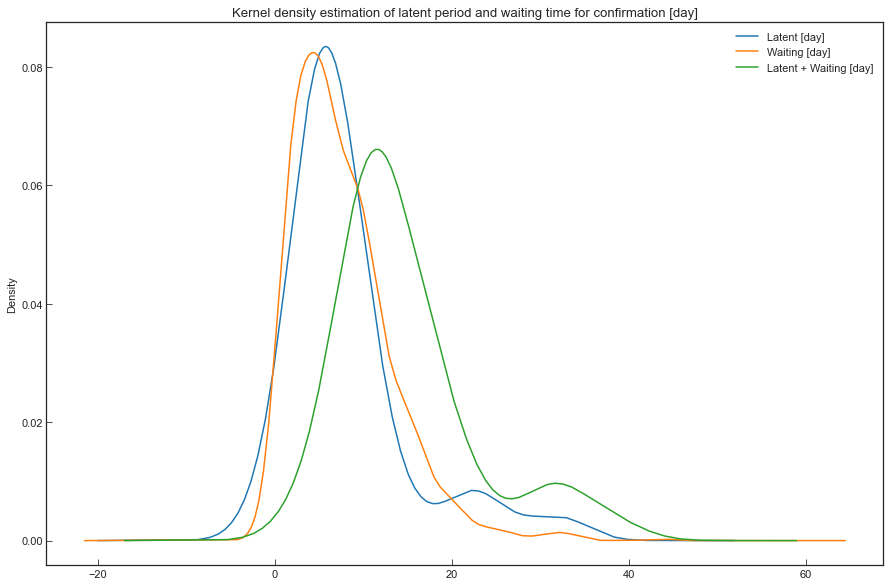

,count,mean,std,min,25%,50%,75%,max
Latent [day],92.0,8.163043,6.934984,-2.0,4.0,6.0,9.00,34.0
Waiting [day],683.0,7.590044,5.582389,0.0,3.0,6.0,10.00,43.0
Latent + Waiting [day],92.0,14.793478,7.838392,2.0,10.0,13.0,17.25,40.0


In [17]:
cols = ["Latent [day]", "Waiting [day]", "Latent + Waiting [day]"]
period_df[cols].plot.kde()
plt.title("Kernel density estimation of latent period and waiting time for confirmation [day]")
plt.show()
period_df[cols].describe().T

### Lets take a look at what are the measures implemented by Canada

Government of Canada took multiple intervention measures to stop the spread of COVID-19. Lets have a look at the same.

In [25]:
canada_action_raw = pd.read_excel("input/covid-19-intervention-scan-data-tables-en.xlsx", sheet_name = "Intervention scan", header=2)

# canada_action_raw.head()

 ### Data Cleaning

In [27]:
def canada_action(canada_action_raw):

    #Removing the columns
    canada_action_raw = canada_action_raw.loc[:,:'Indigenous \npopulation group']
    print(canada_action_raw.columns)
    canada_action_raw.head()

    canada_action_raw[canada_action_raw['Jurisdiction ']=='Can.']

    # Slicing Intervention Summary to get Who implemented the policy what was the policy and how long it will be effective.

    Intervention_summary = canada_action_raw['Intervention summary'].str.split("Who: |\nWhat: |\nEffective until:",
                                                                                    expand=True)


    # Sliced Columns are expanded into individual columns.

    Intervention_summary.rename(columns={1: "Who Implemented", 2: "What Implemented", 3: "Effective Until"},
                                inplace = True)
    # Intervention_summary.head()

    # concatinating intervention_scan data and intervention summary data.

    canada_action_raw = pd.concat([canada_action_raw,Intervention_summary],axis=1)
    canada_action_raw.head()

    # Dropping Secondary source

    canada_action_raw.drop(['Secondary source',0],axis=1,inplace=True)

    # Renaming the columns

    canada_action_raw.rename(columns = {"Indigenous \npopulation group": "Indigenous population group",'Primary source\n(news release or specific resource)': 'Primary source'},inplace=True)
    # canada_action_raw.head()


    #converting the date column to datetime format and extracting month from it.

    canada_action_raw[canada_action_raw['Date announced']=='No data']

    DateColumns = ['Date announced','Date implemented', 'Effective Until']

    for column in DateColumns:

        canada_action_raw[column] = pd.to_datetime(canada_action_raw[column], infer_datetime_format=True,errors='coerce')
    #intervention_scan_data['Date implemented'] = pd.to_datetime(intervention_scan_data['Date implemented'], infer_datetime_format=True,errors='coerce')
    #intervention_scan_data['Effective Until'] = pd.to_datetime(intervention_scan_data['Effective Until'], infer_datetime_format=True,errors='coerce')

    # Rearranging the columns

    canada_action_raw = canada_action_raw[['Entry ID', 'Jurisdiction ','Level','Date announced','Date implemented',
                                                     'Intervention category','Intervention type','Who Implemented',
                                                     'What Implemented','Effective Until','Indigenous population group',
                                                     'Primary source']]

    return(canada_action_raw.head())

canada_action(canada_action_raw)

Index(['Entry ID', 'Jurisdiction ', 'Date announced', 'Date implemented',
       'Intervention category', 'Intervention type', 'Intervention summary',
       'Primary source\n(news release or specific resource)',
       'Secondary source', 'Level', 'Indigenous \npopulation group'],
      dtype='object')


,Entry ID,Jurisdiction,Level,Date announced,Date implemented,Intervention category,Intervention type,Who Implemented,What Implemented,Effective Until,Indigenous population group,Primary source
0,BC007,B.C.,Provincial/territorial,2020-03-15,2020-03-16,Case management,Case management — test criteria,"BC Centre for Disease Control, Provincial Health Services Authority",Testing criteria first published. Testing is prioritized for patients with respiratory symptoms who are hospitalized or likely to be hospitalized; health care workers; residents of long term care facilities; part of an investigation of a cluster or outbreak.,NaT,No,http://www.bccdc.ca/health-info/diseases-conditions/covid-19/testing/phases-of-covid-19-testing-in-bc
1,ON021,Ont.,Provincial/territorial,2020-03-17,2020-03-17,Closures,Closures — recreation,Office of the Premier,"Closed all facilities providing indoor recreational programs and public libraries, with subsequent extensions (see secondary source column)",2020-06-12,No,https://news.ontario.ca/opo/en/2020/03/ontario-enacts-declaration-of-emergency-to-protect-the-public.html
2,ON022,Ont.,Provincial/territorial,2020-03-17,2020-03-17,Closures,Closures — recreation,Office of the Premier,"Closed all theatres including those offering live performances of music, dance and other art forms, as well as cinemas that show movies and concert venues, with subsequent extensions (see secondary source column)",2020-06-12,No,https://news.ontario.ca/opo/en/2020/03/ontario-enacts-declaration-of-emergency-to-protect-the-public.html
3,ON023,Ont.,Provincial/territorial,2020-03-17,2020-03-17,Closures,Closures — non-essential services,Office of the Premier,"Closures of all bars and restaurants, except to the extent that such facilities provide takeout food and delivery, with subsequent extensions (see secondary source column)",2020-06-12,No,https://news.ontario.ca/opo/en/2020/03/ontario-enacts-declaration-of-emergency-to-protect-the-public.html
4,ON111,Ont.,Provincial/territorial,2020-03-17,2020-03-17,Closures,Closures — daycares,Office of the Premier,"Closures of all licensed child care facilities and EarlyON programs, with subsequent extensions (see secondary source column)",2020-06-12,No,https://news.ontario.ca/opo/en/2020/03/ontario-enacts-declaration-of-emergency-to-protect-the-public.html


### Visualization of cases all over the world

In [36]:
# columns
data_cols = ["Infected", "Fatal", "Recovered"]
#calculating rate
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]

In [31]:
total_df = jhu_data.total()
total_df = total_df.loc[total_df.index<=jhu_last_date, :]
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2021-02-09,106974461,38548936,2343847,66081678,0.021910,0.617733,0.034254
2021-02-10,107414534,38714218,2356616,66343700,0.021939,0.617642,0.034303
2021-02-11,107852995,38877246,2369832,66605917,0.021973,0.617562,0.034357
2021-02-12,108241973,38988267,2383328,66870378,0.022019,0.617786,0.034414
2021-02-13,108305472,38998847,2385043,66921582,0.022021,0.617897,0.034413


### Total Cases over Time

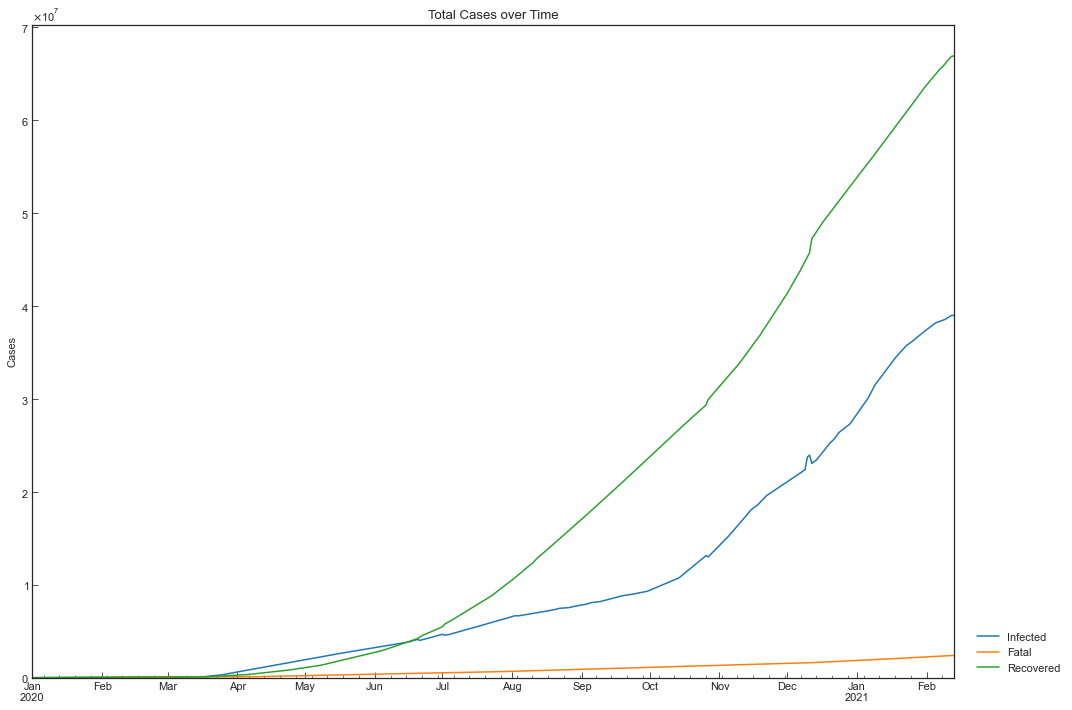

In [32]:
cs.line_plot(total_df[data_cols], "Total Cases over Time")

### Rate over Time

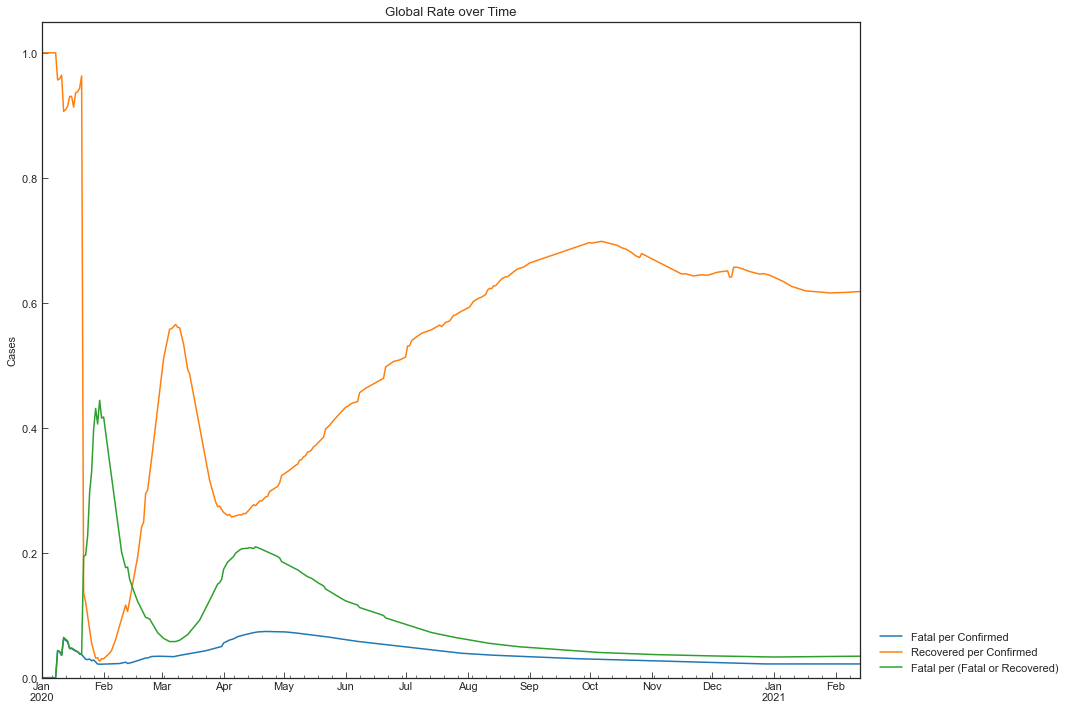

In [37]:
cs.line_plot(total_df[rate_cols], "Global Rate over Time")

### Kernel Density Estimation

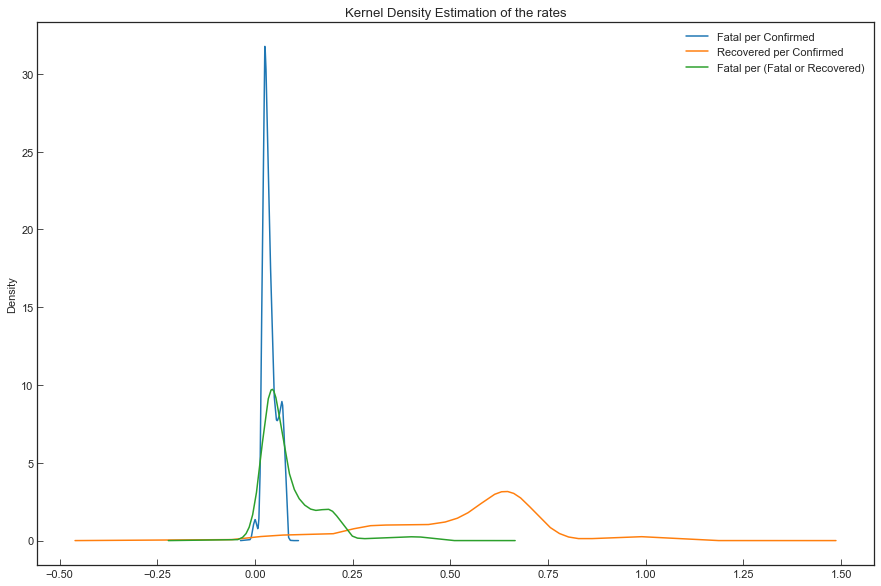

In [41]:
total_df[rate_cols].plot.kde()
plt.title("Kernel Density Estimation of the rates")
plt.show()

In [44]:
total_df[rate_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Fatal per Confirmed,409.0,0.037455,0.016850,0.000000,0.023667,0.033210,0.046564,0.074176
Recovered per Confirmed,409.0,0.534208,0.200169,0.026271,0.406821,0.615975,0.653727,1.000000
Fatal per (Fatal or Recovered),409.0,0.087874,0.076391,0.000000,0.036390,0.056274,0.117013,0.443878


### Grouping by growth factor

We are going to group countries, by the rate of their confirmed cases. 
1. Countries where growth factor is > 1
2. Countries where growth factor < 1

For calculating growth factor we will use
Growth Factor = ΔCn/ΔCn-1

In [74]:

covid_df = jhu_data.cleaned()
df = covid_df.pivot_table(
index="Date", columns="Country", values="Confirmed", aggfunc="sum").fillna(method='ffill').fillna(0)

#growth factor

df = df.diff()/df.diff().shift(freq="D")
df = df.replace(np.inf,np.nan).fillna(1.0)

#Rolling mean (window: 7 days)

df = df.rolling(7).mean().dropna().loc[:covid_df["Date"].max(),:]

growth_value_df = df.round(2)

growth_value_df


Country,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,"Virgin Islands, U.S.",Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-07,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
2020-01-08,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
2020-01-09,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
2020-01-10,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
2020-01-11,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-03,1.18,1.02,1.01,1.0,0.97,1.48,0.43,1.01,1.32,0.96,...,0.97,1.00,1.12,1.0,1.06,10.22,0.76,0.71,1.04,1.01
2021-02-04,1.29,1.03,1.01,1.0,1.03,1.22,0.57,1.02,1.26,1.07,...,0.97,1.03,1.09,1.0,1.04,3.24,0.97,0.86,1.06,1.04
2021-02-05,1.19,1.03,0.99,1.0,0.98,1.23,0.50,1.01,1.38,1.01,...,0.97,0.98,1.13,1.0,1.04,3.53,0.92,0.86,1.06,1.03


In [75]:
df = growth_value_df

df = df.iloc[-7:,:].T

day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]

#Grouping
more_col, less_col = "GrowthFactor>1[straight days]","GrowthFactor<1[straight days]"
df[more_col] = ((growth_value_df)>1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = ((growth_value_df)<1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col,less_col]].apply(lambda x : "outbreaking" if x[0] >= 7 else "Stopping" if x[1] >=7 else "Crossroad", axis=1)

#Sorting
df = df.loc[:,["Group", more_col, less_col, *day_cols]]
df = df.sort_values(["Group", more_col, less_col], ascending = False)
growth_df = df.copy()
growth_df

Date,Group,GrowthFactor>1[straight days],GrowthFactor<1[straight days],01Feb2021,02Feb2021,03Feb2021,04Feb2021,05Feb2021,06Feb2021,07Feb2021
Country,,,,,,,,,,
Belgium,outbreaking,206,0,1.28,1.27,1.27,1.27,1.25,1.24,1.23
Slovakia,outbreaking,189,0,1.22,1.36,1.34,1.34,1.34,1.34,1.33
Bulgaria,outbreaking,126,0,1.61,1.62,1.62,1.66,1.63,1.64,1.64
North Macedonia,outbreaking,103,0,1.66,1.63,1.62,1.65,1.64,1.67,1.67
Slovenia,outbreaking,84,0,1.35,1.33,1.32,1.31,1.32,1.32,1.32
...,...,...,...,...,...,...,...,...,...,...
Tajikistan,Crossroad,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Tanzania,Crossroad,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Uganda,Crossroad,0,0,1.08,1.05,1.06,0.97,1.04,1.03,1.00


In [76]:
# merging both the columns

df = pd.merge(covid_df, growth_df["Group"].reset_index(), on="Country")
covid_df = df.loc[:, ["Date", "Group", *covid_df.columns[1:]]]
covid_df


,Date,Group,Country,Province,Confirmed,Infected,Fatal,Recovered
0,2020-01-01,outbreaking,Afghanistan,-,0,0,0,0
1,2020-01-02,outbreaking,Afghanistan,-,0,0,0,0
2,2020-01-03,outbreaking,Afghanistan,-,0,0,0,0
3,2020-01-04,outbreaking,Afghanistan,-,0,0,0,0
4,2020-01-05,outbreaking,Afghanistan,-,0,0,0,0
...,...,...,...,...,...,...,...,...
401337,2021-02-09,Crossroad,Japan,-,406766,31477,6476,368813
401338,2021-02-10,Crossroad,Japan,-,408186,29094,6557,372535
401339,2021-02-11,Crossroad,Japan,-,410012,27880,6678,375454
401340,2021-02-12,Crossroad,Japan,-,411751,26953,6774,378024


### Grouping Outbreaking Countries

In [78]:
growth_df[growth_df["Group"] == "outbreaking"].head()

Date,Group,GrowthFactor>1[straight days],GrowthFactor<1[straight days],01Feb2021,02Feb2021,03Feb2021,04Feb2021,05Feb2021,06Feb2021,07Feb2021
Country,,,,,,,,,,
Belgium,outbreaking,206,0,1.28,1.27,1.27,1.27,1.25,1.24,1.23
Slovakia,outbreaking,189,0,1.22,1.36,1.34,1.34,1.34,1.34,1.33
Bulgaria,outbreaking,126,0,1.61,1.62,1.62,1.66,1.63,1.64,1.64
North Macedonia,outbreaking,103,0,1.66,1.63,1.62,1.65,1.64,1.67,1.67
Slovenia,outbreaking,84,0,1.35,1.33,1.32,1.31,1.32,1.32,1.32


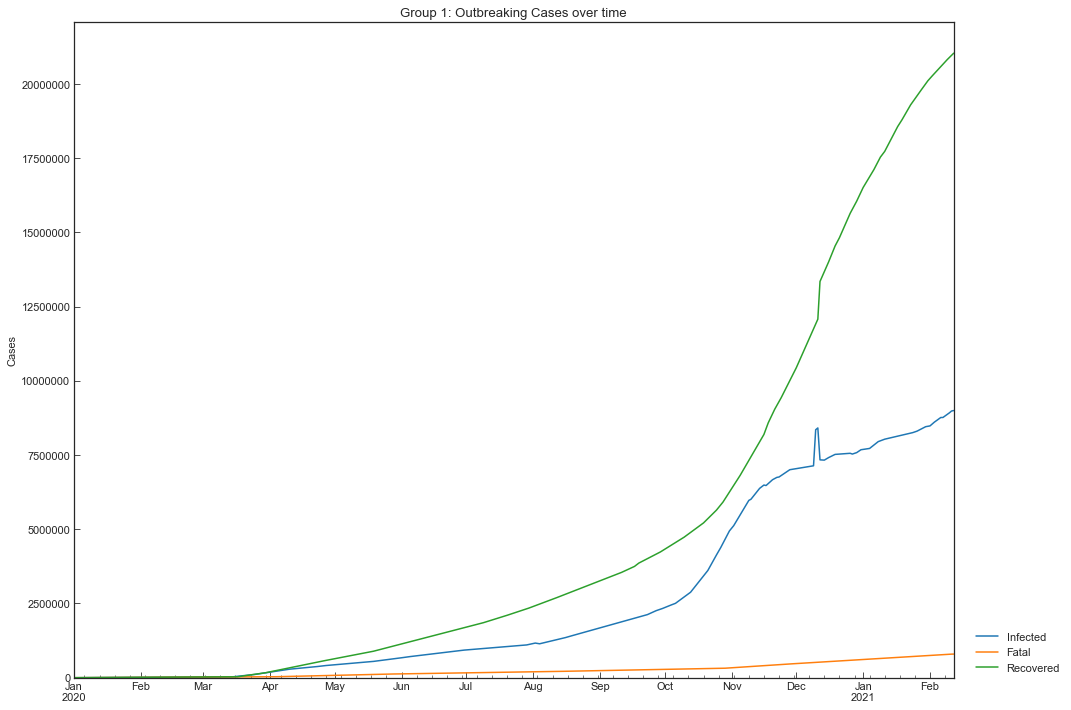

,Infected,Fatal,Recovered
Date,,,
2021-02-08,8807606,784952,20740912
2021-02-09,8854821,788174,20820410
2021-02-10,8921823,790946,20896500
2021-02-11,8983188,793737,20971728
2021-02-12,8999575,795471,21036338


In [106]:
df = covid_df.loc[covid_df["Group"] == "outbreaking", ["Date", *data_cols]]
df = df.groupby("Date").sum()
df = df.iloc[:-1,:]
if not df.empty:
    cs.line_plot(df,"Group 1: Outbreaking Cases over time", y_integer=True)
df.tail()

### Grouping Stopping Country

In [85]:
growth_df[growth_df["Group"]=="Stopping"].head()

Date,Group,GrowthFactor>1[straight days],GrowthFactor<1[straight days],01Feb2021,02Feb2021,03Feb2021,04Feb2021,05Feb2021,06Feb2021,07Feb2021
Country,,,,,,,,,,
Gabon,Stopping,0,196,0.57,0.57,0.57,0.57,0.57,0.57,0.57
Oman,Stopping,0,158,0.72,0.74,0.73,0.76,0.76,0.76,0.76
Equatorial Guinea,Stopping,0,134,0.57,0.57,0.57,0.71,0.71,0.71,0.71
Costa Rica,Stopping,0,126,0.79,0.78,0.78,0.79,0.77,0.77,0.77
El Salvador,Stopping,0,115,0.60,0.60,0.60,0.67,0.68,0.68,0.54


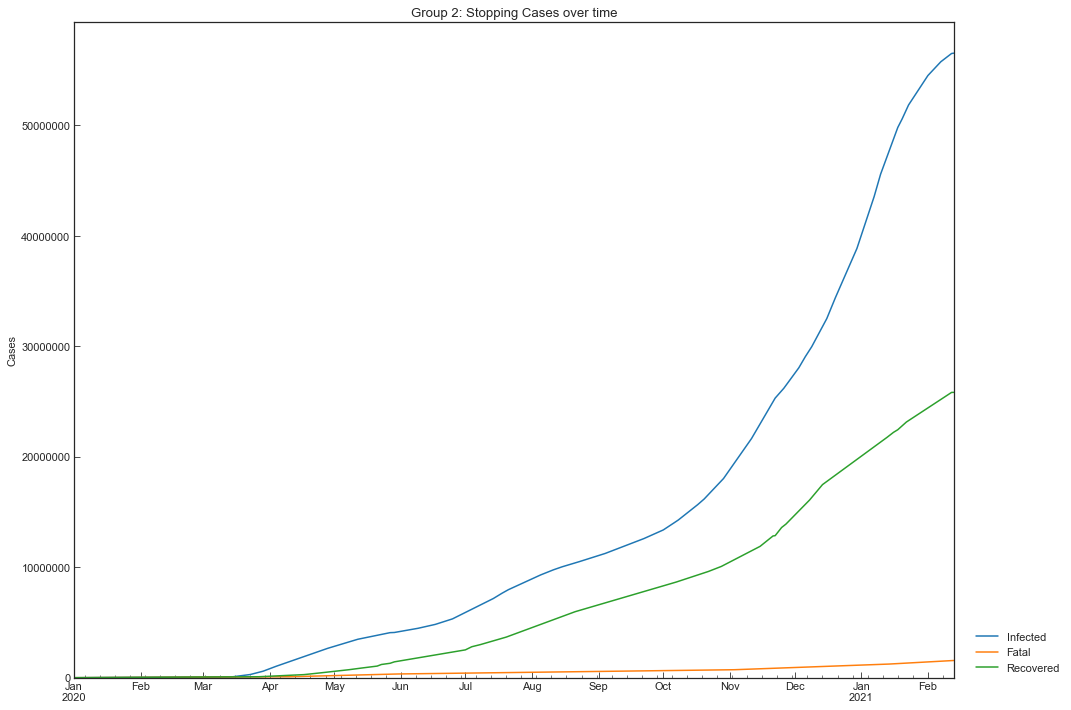

,Infected,Fatal,Recovered
Date,,,
2020-01-01,10,0,0
2020-01-02,27,0,0
2020-01-03,41,0,0
2020-01-04,55,0,0
2020-01-05,67,0,0


In [105]:
df = covid_df.loc[covid_df["Group"] == "Stopping", ["Date", *data_cols]]
df = df.groupby("Date").sum()
if not df.empty:
    cs.line_plot(df,"Group 2: Stopping Cases over time", y_integer=True)
df.head()

### Grouping crossroad Countries

In [97]:
growth_df[growth_df["Group"]=="Crossroad"]

Date,Group,GrowthFactor>1[straight days],GrowthFactor<1[straight days],01Feb2021,02Feb2021,03Feb2021,04Feb2021,05Feb2021,06Feb2021,07Feb2021
Country,,,,,,,,,,
Barbados,Crossroad,6,0,0.73,1.03,1.02,1.08,1.06,1.08,1.19
Cote d'Ivoire,Crossroad,6,0,0.93,1.09,1.01,1.25,1.18,1.24,1.25
Monaco,Crossroad,6,0,0.93,1.16,1.19,1.13,1.30,1.27,1.28
Suriname,Crossroad,6,0,0.88,1.34,1.36,1.35,1.23,1.34,1.31
Zimbabwe,Crossroad,6,0,0.97,1.05,1.01,1.04,1.03,1.01,1.02
...,...,...,...,...,...,...,...,...,...,...
Tajikistan,Crossroad,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Tanzania,Crossroad,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
Uganda,Crossroad,0,0,1.08,1.05,1.06,0.97,1.04,1.03,1.00


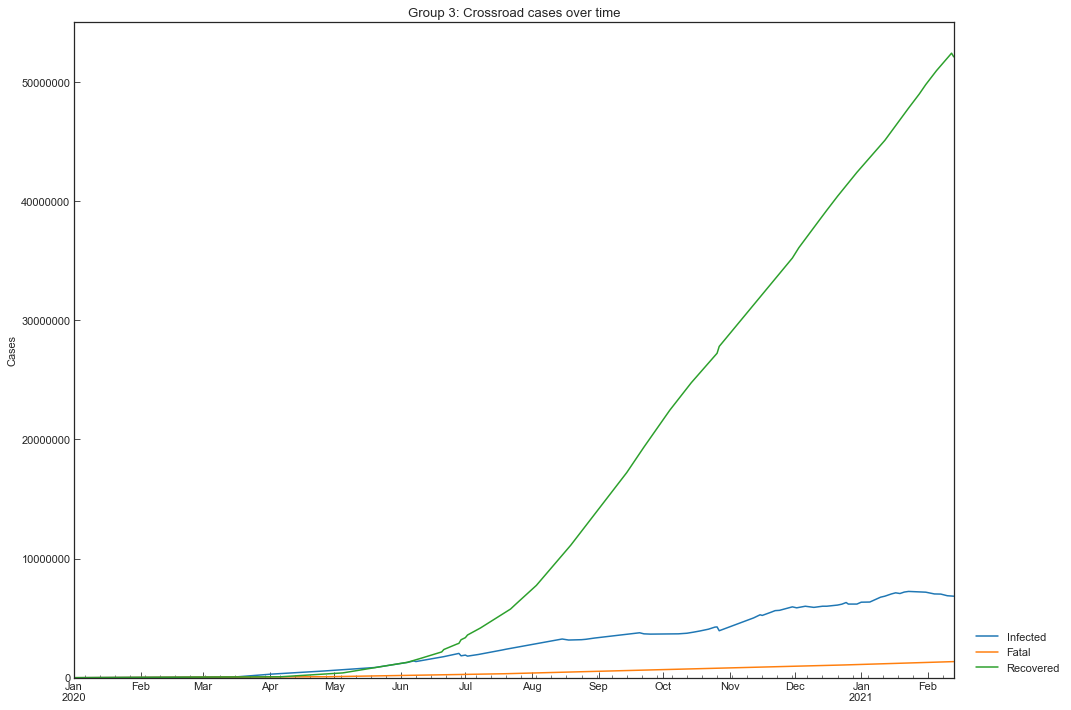

,Infected,Fatal,Recovered
Date,,,
2021-02-09,6870151,1339247,51826975
2021-02-10,6882108,1344892,52020486
2021-02-11,6875919,1350958,52225733
2021-02-12,6865905,1356245,52433146
2021-02-13,6842500,1350871,52125997


In [108]:
df = covid_df.loc[covid_df['Group']=="Crossroad",["Date",*data_cols]].groupby("Date").sum()

if not df.empty:
    cs.line_plot(df, "Group 3: Crossroad cases over time", y_integer=True)
df.tail()

### SIR Model

 The SIR epidemic model is a simple mathematical description of the spread of disease in a population. It divides the population into 3 compartments which may vary as a fucntion of time t, and space x:
 
 S(t) = are those who are susceptible but not infected yet.
 I(t) = are those who are infected.
 R(t) = are those who have recovered from the disease and now have immunity to it.
 
 The SIR model describes the changes in the population of each of three compartments using &beta; and &gamma;. &beta; describes the effective contact rate of the disease. &gamma; describes the mean recovery rate. An infected individual comes into contact with &beta;N other individuals per unit time (of which the fraction that are a susceptible to contracting the disease of S/N). 1/&gamma; is the mean period of time during which an infected individual can pass it on.
 
 
 
 The differential equations describing this model were first derived by Kermack and McKendrick:
 
 dS/dT = &beta;SI/N </br>
 dI/dT = &beta;SI/N - &gamma;I  </br>
 dR/dT = &gamma;I </br>
 
 N = S+I+R is the total population, T is the elapsed time from the start date.

#### Non-dimensional SIR Model

To make our model we will remove the units of the variable from ODE.
set (S,I,R) = N x (x,y,z) and (T, &beta;, &gamma;) = (&tau;t, &tau;<sup>-1</sup>&rho;, &tau;<sup>-1</sup>&sigma;)

This results in the ODE

dx/dt = -&rho;xy </br>
dy/dt = &rho;xy - &sigma;y </br>
dz/dt = &sigma;y

where N is the total population and &tau; is coefficient ([min], is an integer to simplify)

The range of variables and parameters:

0 <= (x,y,z,&rho;,&sigma;) <=1 </br>
1<= &tau; <= 1440

Basic reproduction number, Non-dimensional parameter, is defined as

R<sub>o</sub> = &rho;&sigma;<sup>-1</sup> = &beta;&gamma;<sup>-1</sup>

Estimated Mean Values of R<sub>o</sub>: R<sub>o</sub> means "the average number of secondary infections caused by an infected host"

In [119]:
# this is example data to simulate the SIR Model with tau = 1440 (max) and start date 01Jan2020

example_data = cs.ExampleData(tau=1440,start_date='01Jan2020')
example_data.cleaned()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


In [120]:
# Model name
print(cs.SIR.NAME)
# Example parameter values
pprint(cs.SIR.EXAMPLE, compact=True)

SIR
{'param_dict': {'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal or Recovered': 0, 'Infected': 1000, 'Susceptible': 999000}}


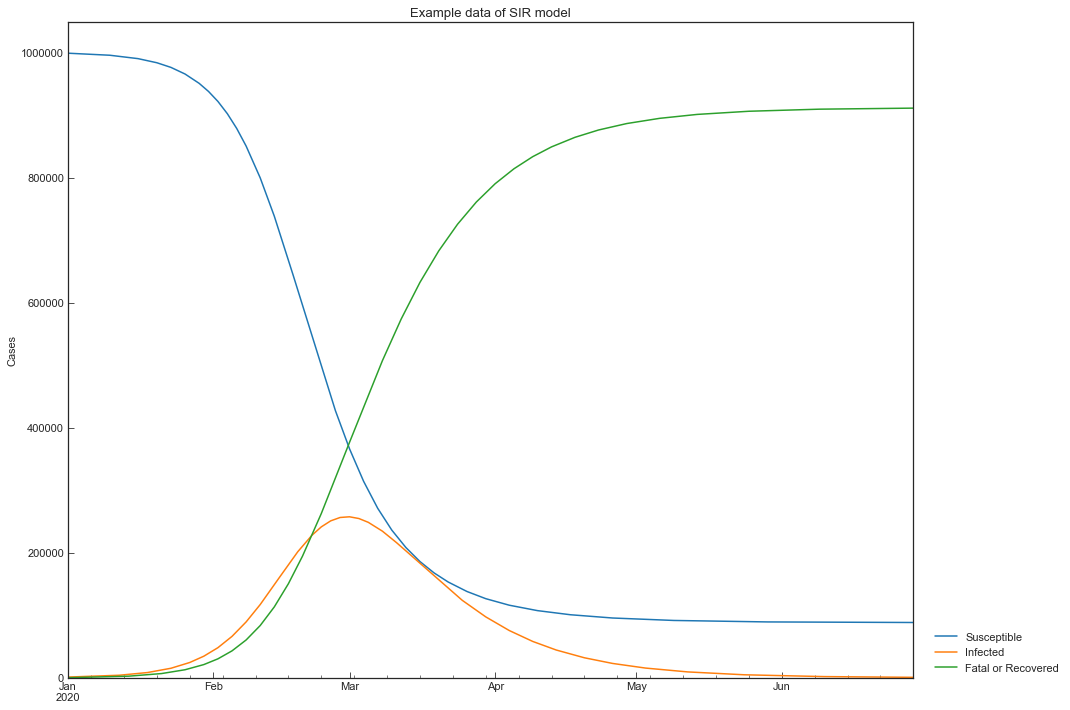

In [121]:
model = cs.SIR
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)


 There is an inflection point of number of currently infected cases per total population(y). At this point value of susceptible cases (x) per total population is nearly equal to 1/&rho;

In [122]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.366211, 0.37453183520599254)

### SIR model Implementation

We'll use differential equations to calculate the population change over time.

In [161]:
# The differentail equation to define SIR Model:

def deriv(state, t, N, beta, gamma):
    
    S, I, R = state
    
    #change in S population over time
    dsdt = -beta * S* I / N
    #change in I population over time
    dIdt = beta * S * I / N - gamma * I
    #change in R population over time
    dRdt = gamma * I
    
    return dsdt, dIdt, dRdt

### Preparing data for the model

Total population is 37057765


,susceptible,infected,recovered,day
0,37053786,3749,230,0
1,37053143,4366,256,1
2,37052438,4825,502,2
3,37051571,5672,522,3
4,37050430,6267,1068,4
...,...,...,...,...
320,36267877,39179,750709,320
321,36264787,38242,754736,321
322,36261690,37747,758328,322
323,36258621,36944,762200,323


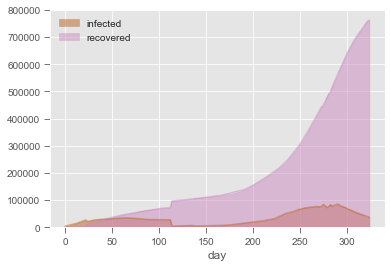

In [179]:
canada_subset = jhu_data.subset("Canada", province=None)
# canada_subset.head()


#total population
total_population = population_data.value("Canada", province = None)
print("Total population is", total_population)
#susceptible  = Total_population - infected - recovered

canada_subset["Susceptible"] = total_population - canada_subset["Infected"] - canada_subset["Recovered"]
canada_subset['day'] = range(0,len(canada_subset))

SIR_Model_subset = canada_subset[["Susceptible","Infected", "Recovered", "day"]]
SIR_Model_subset.columns = map(str.lower, SIR_Model_canada_subset.columns)

SIR_Model_subset.plot(x='day',
        y=['infected', 'recovered'],
        color=['#bb6424', '#cc8ac0'],
        kind='area',
        stacked=False)
SIR_Model_subset

We'll start by taking only the canadian population as our data frame.

Effective contact rate is transmission rate * contact rate, so:
 - 5% transmission rate and 5 contacts a day is 0.05*5 = 0.25
 
Recovery rate is 1/day
 - 4 day recovery rate 1/4 = 0.25

R0 is 3.15
37057765


,susceptible,infected,recovered,day
0,3.705776e+07,1.000000,0.000000e+00,0
1,3.705776e+07,1.107805,5.014205e-02,1
2,3.705776e+07,1.227233,1.056897e-01,2
3,3.705776e+07,1.359535,1.672257e-01,3
4,3.705776e+07,1.506100,2.353955e-01,4
...,...,...,...,...
320,1.876069e+06,85060.590187,3.509664e+07,320
321,1.875436e+06,81723.150410,3.510061e+07,321
322,1.874828e+06,78516.461328,3.510442e+07,322
323,1.874244e+06,75435.415772,3.510809e+07,323


<Figure size 1080x720 with 0 Axes>

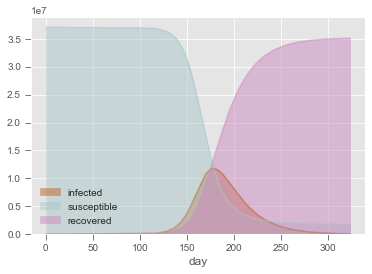

In [184]:
effective_contact_rate = 0.15
recovery_rate = 1/21

#calculate R0
print("R0 is", effective_contact_rate/recovery_rate)
print(total_population)
recovered = 0
infected = 1
susceptible = total_population - infected - recovered

# number of days
# days = len(jhu_data.subset("Canada", province=None))
days = range(0,len(jhu_data.subset("Canada", province=None)))

#use of differentail equation

ret = odeint(deriv,
            [susceptible, infected, recovered],
            days,
            args = (total_population, effective_contact_rate, recovery_rate))

S, I , R = ret.T

#Build a dataframe

df = pd.DataFrame({
    'susceptible': S,
    'infected': I,
    'recovered': R,
    'day': days
})

plt.style.use('ggplot')
plt.figure(figsize=(15,10))
df.plot(x='day',
        y=['infected', 'susceptible', 'recovered'],
        color=['#bb6424', '#aac6ca', '#cc8ac0'],
        kind='area',
        stacked=False)
df

range(0, 326)

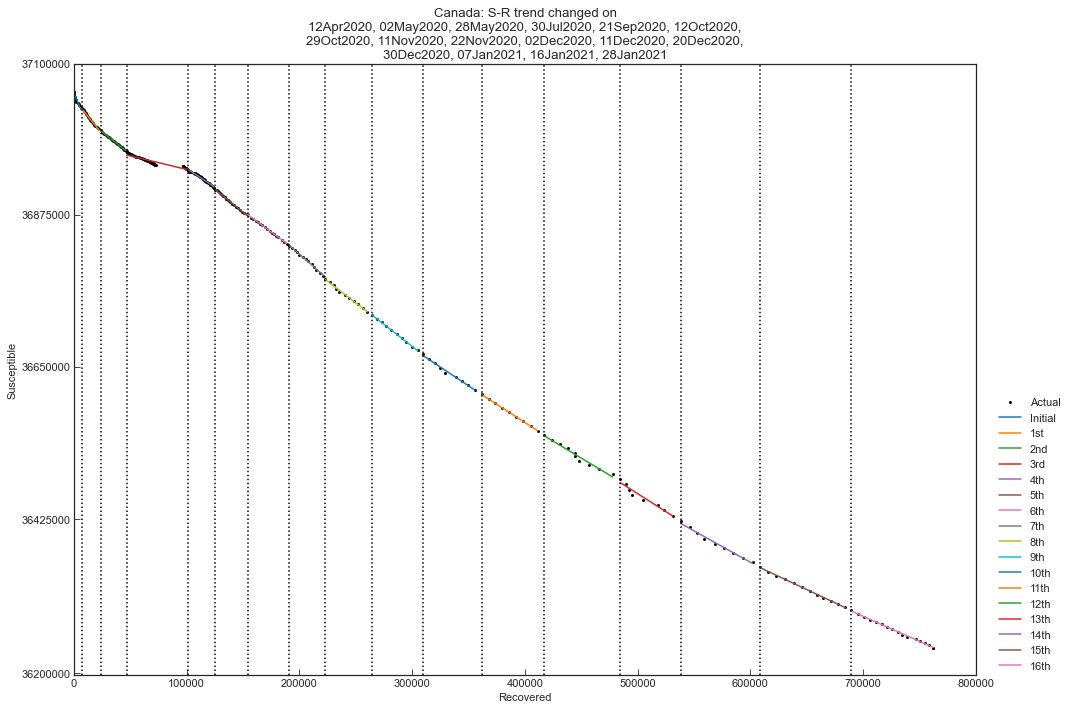

In [124]:
# can_scenario = cs.Scenario(jhu_data, population_data, "Canada")
# _ = can_scenario.trend()

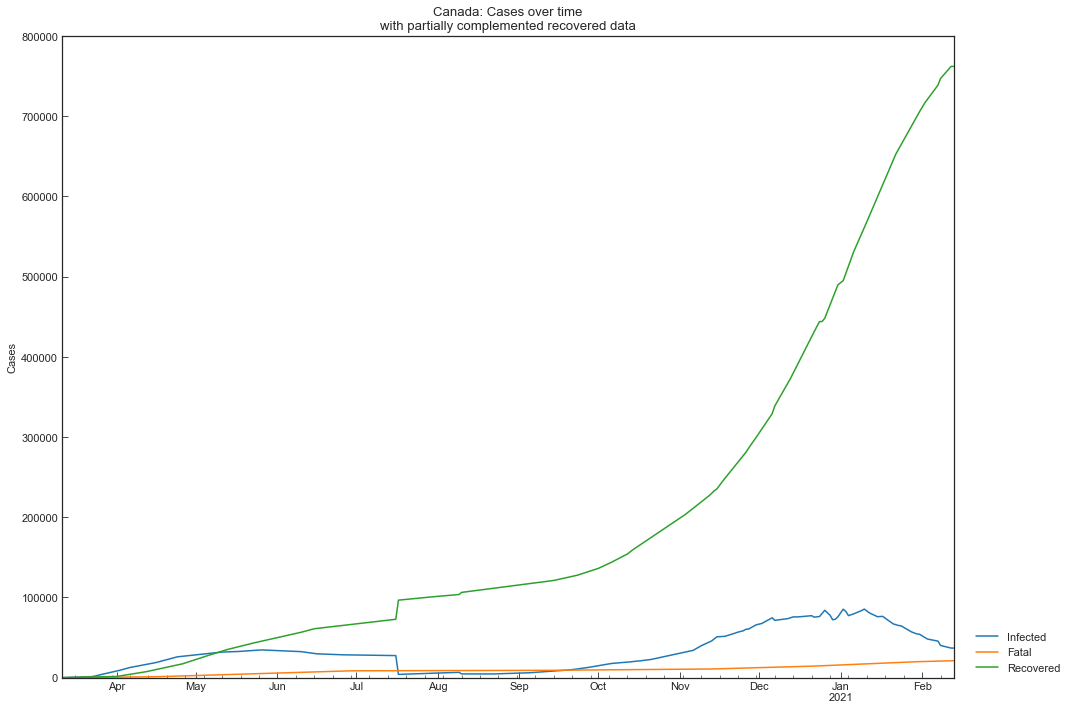

,Date,Infected,Fatal,Recovered
335,2021-02-09,39179,20909,750709
336,2021-02-10,38242,21004,754736
337,2021-02-11,37747,21088,758328
338,2021-02-12,36944,21162,762200
339,2021-02-13,36944,21162,762200


In [125]:
# can_scenario.records().tail()

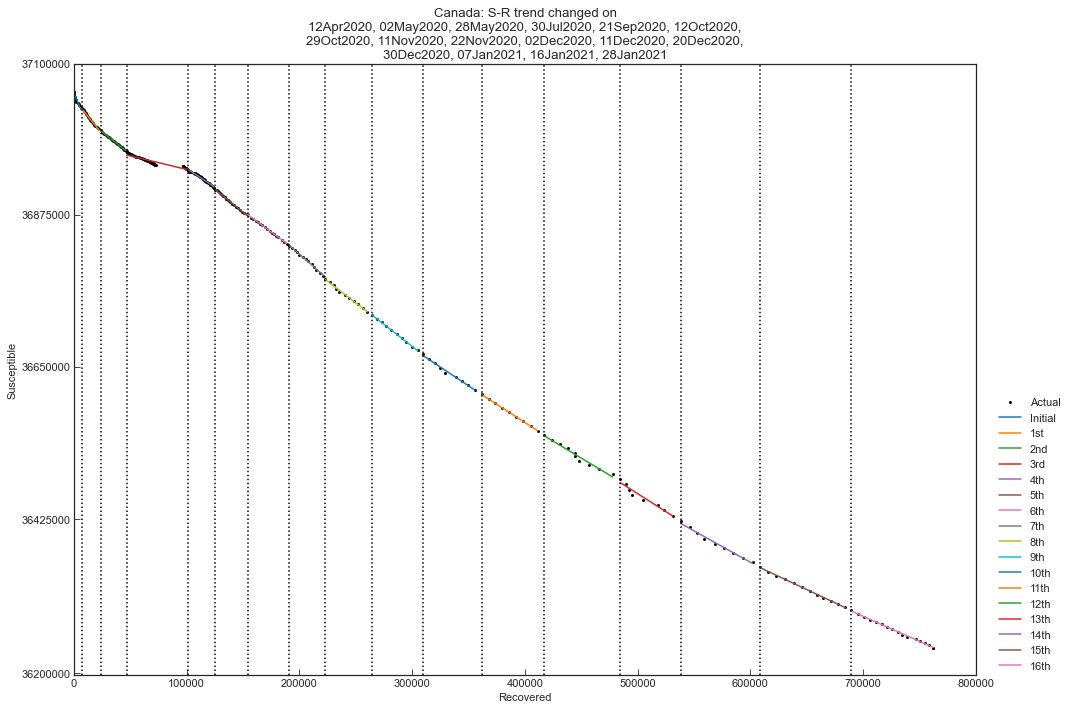

In [126]:
# can_scenario.trend()

In [127]:
# can_scenario.summary()

,Type,Start,End,Population
0th,Past,11Mar2020,11Apr2020,37057765
1st,Past,12Apr2020,01May2020,37057765
2nd,Past,02May2020,27May2020,37057765
3rd,Past,28May2020,29Jul2020,37057765
4th,Past,30Jul2020,20Sep2020,37057765
5th,Past,21Sep2020,11Oct2020,37057765
6th,Past,12Oct2020,28Oct2020,37057765
7th,Past,29Oct2020,10Nov2020,37057765
8th,Past,11Nov2020,21Nov2020,37057765
9th,Past,22Nov2020,01Dec2020,37057765


In [128]:
# can_scenario.estimate(cs.SIRF, timeout =120)


<SIR-F model: parameter estimation>
Running optimization with 12 CPUs...
	 8th phase (16Jan2021 - 27Jan2021): finished  565 trials in 0 min 20 sec
Completed optimization. Total: 2 min 50 sec


In [129]:
# can_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/gamma [day],1/alpha2 [day],1/beta [day],alpha1 [-],RMSLE,Trials,Runtime
0th,Past,11Mar2020,11Apr2020,37057765,SIR-F,6.71,0.030354,0.000269,0.093284,0.013214,720,37,1860,5,0.030,0.860164,1350,2 min 0 sec
1st,Past,12Apr2020,01May2020,37057765,SIR-F,1.98,0.077580,0.000261,0.037362,0.017107,720,29,1915,13,0.078,0.028958,1346,2 min 0 sec
2nd,Past,02May2020,27May2020,37057765,SIR-F,1.25,0.104613,0.000157,0.019302,0.013654,720,36,3189,25,0.105,0.035138,1352,2 min 0 sec
3rd,Past,28May2020,29Jul2020,37057765,SIR-F,0.38,0.109155,0.000449,0.006039,0.013687,720,36,1113,82,0.109,0.307599,1497,2 min 0 sec
4th,Past,30Jul2020,20Sep2020,37057765,SIR-F,1.02,0.019169,0.000002,0.039026,0.037471,720,13,264806,12,0.019,0.117886,1343,2 min 0 sec
5th,Past,21Sep2020,11Oct2020,37057765,SIR-F,1.37,0.000741,0.000570,0.059618,0.042829,720,11,876,8,0.001,0.018395,1361,2 min 0 sec
6th,Past,12Oct2020,28Oct2020,37057765,SIR-F,1.23,0.000232,0.000456,0.055447,0.044451,720,11,1097,9,0.000,0.012074,616,0 min 50 sec
7th,Past,29Oct2020,10Nov2020,37057765,SIR-F,1.45,0.000685,0.000628,0.054650,0.037137,720,13,796,9,0.001,0.013776,394,0 min 30 sec
8th,Past,11Nov2020,21Nov2020,37057765,SIR-F,1.32,0.000395,0.000815,0.050282,0.037256,720,13,613,9,0.000,0.015407,880,1 min 10 sec
9th,Past,22Nov2020,01Dec2020,37057765,SIR-F,1.23,0.017214,0.000005,0.045850,0.036635,720,13,109628,10,0.017,0.011145,314,0 min 20 sec


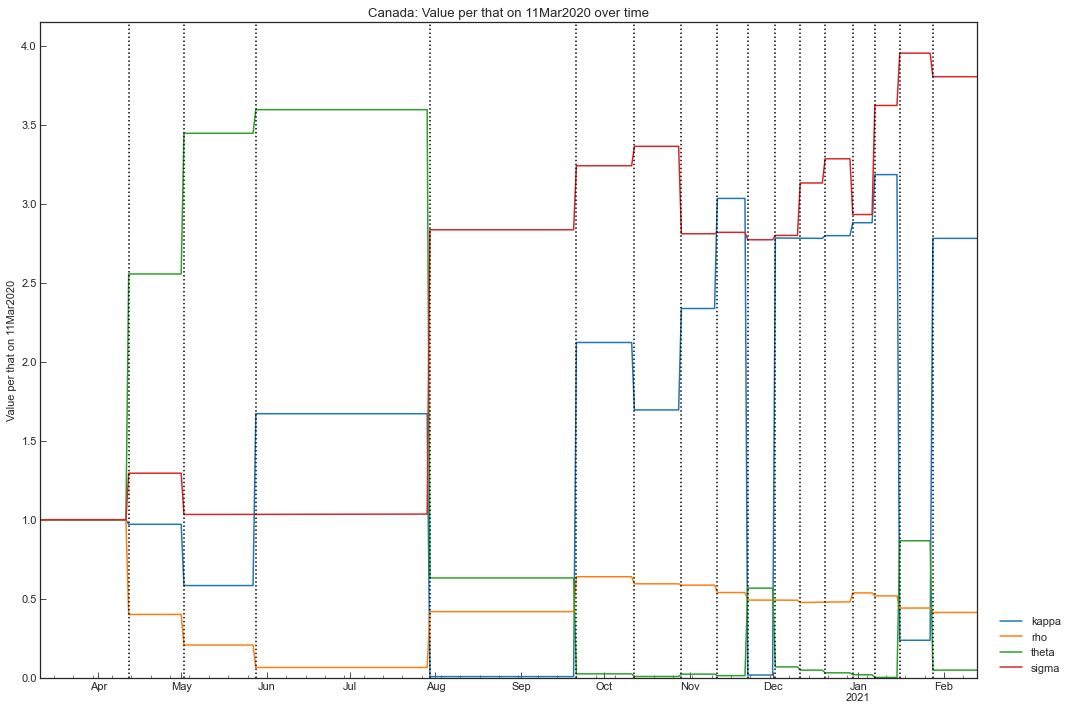

In [130]:
# _ = can_scenario.history_rate()

In [136]:
covid_df[covid_df["Country"]=="Canada"]

,Date,Group,Country,Province,Confirmed,Infected,Fatal,Recovered
21730,2020-01-01,Stopping,Canada,-,0,0,0,0
21731,2020-01-02,Stopping,Canada,-,0,0,0,0
21732,2020-01-03,Stopping,Canada,-,0,0,0,0
21733,2020-01-04,Stopping,Canada,-,0,0,0,0
21734,2020-01-05,Stopping,Canada,-,0,0,0,0
...,...,...,...,...,...,...,...,...
27465,2021-02-09,Stopping,Canada,Northwest Territories,33,2,0,31
27466,2021-02-10,Stopping,Canada,Northwest Territories,34,3,0,31
27467,2021-02-11,Stopping,Canada,Northwest Territories,38,6,0,32
27468,2021-02-12,Stopping,Canada,Northwest Territories,38,6,0,32
